In [ ]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import os
import time

In [ ]:
# path_to_file = tf.keras.utils.get_file('pickup_training_data.txt', 'https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt')

In [ ]:
path_to_file = 'supersampletext.txt'

In [ ]:
# Read, then decode for py2 compat.
text = open(path_to_file, 'rb').read().decode(encoding='utf-8')
# length of text is the number of characters in it
print(f'Length of text: {len(text)} characters')

Length of text: 137632 characters


In [ ]:
print(text[:250])


﻿Are you a pair of glasses? You don’t appear to be one of my contacts.
	Want to play agent and fondle my package?
	God has used you to teach me what true love really is
	My body is a temple, so make sure you take your shoes off before you come in.


In [ ]:
text = text.lower()

In [ ]:
vocab = sorted(set(text))
print(f'{len(vocab)} unique characters')


71 unique characters


In [ ]:
# example_texts = ['abcdefg', 'xyz']
# chars = tf.strings.unicode_split(example_texts, input_encoding='UTF-8')
# chars


In [ ]:
# splits string into unicode characters
chars = tf.strings.unicode_split(text, input_encoding='UTF-8')
chars

<tf.Tensor: shape=(137632,), dtype=string, numpy=array([b'\xef\xbb\xbf', b'a', b'r', ..., b'c', b'k', b'.'], dtype=object)>

In [ ]:
# assigns ids to each char
ids_from_chars = tf.keras.layers.StringLookup(
    vocabulary=list(vocab), mask_token=None)

In [ ]:
# ids for each char
ids = ids_from_chars(chars)
ids

<tf.Tensor: shape=(137632,), dtype=int64, numpy=array([70, 36, 53, ..., 38, 46, 17])>

In [ ]:
# so we can convert id into char
chars_from_ids = tf.keras.layers.StringLookup(
    vocabulary=ids_from_chars.get_vocabulary(), invert=True, mask_token=None)

In [ ]:
# data = tf.constant([["a", "c", "d"], ["d", "z", "b"]])
# layer = tf.keras.layers.StringLookup()
# layer.adapt(vocab)
# layer.get_vocabulary()

In [ ]:
# function that translates ids into chars into a coherent string
def text_from_ids(ids):
  return tf.strings.reduce_join(chars_from_ids(ids), axis=-1)

Instead of assigning ids to words, we give them to the characters. Then, through RNN, we will try to predict the output with an input of a sequence of characters.

As a result, we have to produce example sequences.
Each input sequence has a length.
The next input has lenght+1 i.e. length = 4; great = input: grea --> output: reat

In [ ]:
all_ids = ids_from_chars(tf.strings.unicode_split(text, 'UTF-8'))
all_ids

<tf.Tensor: shape=(137632,), dtype=int64, numpy=array([70, 36, 53, ..., 38, 46, 17])>

In [ ]:
ids_dataset = tf.data.Dataset.from_tensor_slices(all_ids)


In [ ]:
# for each id in the dataset from our ids, print 10
for ids in ids_dataset.take(10):
    print(chars_from_ids(ids).numpy().decode('utf-8'))

﻿
a
r
e
 
y
o
u
 
a


In [ ]:
seq_length = 50

In [ ]:
sequences = ids_dataset.batch(seq_length+1, drop_remainder=True)

# a sequence example
for seq in sequences.take(1):
  print(chars_from_ids(seq))

tf.Tensor(
[b'\xef\xbb\xbf' b'a' b'r' b'e' b' ' b'y' b'o' b'u' b' ' b'a' b' ' b'p'
 b'a' b'i' b'r' b' ' b'o' b'f' b' ' b'g' b'l' b'a' b's' b's' b'e' b's'
 b'?' b' ' b'y' b'o' b'u' b' ' b'd' b'o' b'n' b'\xe2\x80\x99' b't' b' '
 b'a' b'p' b'p' b'e' b'a' b'r' b' ' b't' b'o' b' ' b'b' b'e' b' '], shape=(51,), dtype=string)


In [ ]:
# more legible
for seq in sequences.take(5):
  print(text_from_ids(seq).numpy())

b'\xef\xbb\xbfare you a pair of glasses? you don\xe2\x80\x99t appear to be '
b'one of my contacts.\r\n\twant to play agent and fondle'
b' my package?\r\n\tgod has used you to teach me what tr'
b'ue love really is\r\n\tmy body is a temple, so make su'
b're you take your shoes off before you come in.\r\n\tyo'


In [ ]:
# takes sequence, duplicates, and shifts it
def split_input_target(sequence):
    input_text = sequence[:-1]
    target_text = sequence[1:]
    return input_text, target_text

In [ ]:
dataset = sequences.map(split_input_target)
train_dataset = dataset.take(int(len(dataset) * 0.8)) # 80% of data
test_dataset = dataset.skip(int(len(dataset) * 0.8)) # 20% of data

In [ ]:
for input_example, target_example in dataset.take(1):
    print("Input :", text_from_ids(input_example).numpy())
    print("Target:", text_from_ids(target_example).numpy())

Input : b'\xef\xbb\xbfare you a pair of glasses? you don\xe2\x80\x99t appear to be'
Target: b'are you a pair of glasses? you don\xe2\x80\x99t appear to be '


Below, we shuffle data and pack into batches to be fed into the model.

In [ ]:
# Batch size
BATCH_SIZE = 64

# Buffer size to shuffle the dataset
# (TF data is designed to work with possibly infinite sequences,
# so it doesn't attempt to shuffle the entire sequence in memory. Instead,
# it maintains a buffer in which it shuffles elements).
BUFFER_SIZE = 10000

dataset = (
    dataset
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.experimental.AUTOTUNE))

train_dataset = (
    train_dataset
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.experimental.AUTOTUNE))

test_dataset = (
    test_dataset
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.experimental.AUTOTUNE))


dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(64, 50), dtype=tf.int64, name=None), TensorSpec(shape=(64, 50), dtype=tf.int64, name=None))>

In [ ]:
dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(64, 64, 50), dtype=tf.int64, name=None), TensorSpec(shape=(64, 64, 50), dtype=tf.int64, name=None))>

In [ ]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(64, 50), dtype=tf.int64, name=None), TensorSpec(shape=(64, 50), dtype=tf.int64, name=None))>

## Building the Actual Model!

In [ ]:
# Length of the vocabulary in StringLookup Layer
vocab_size = len(ids_from_chars.get_vocabulary())
# The embedding dimension
embedding_dim = 256
# Number of RNN units
rnn_units = 1024

In [ ]:
# tf.random.set_seed(1234)
# model = tf.keras.Sequential()
# # Must define the input shape in the first layer of the neural network
# # A dense layer is what we have been using so far.
# # This one has 12 nodes in it and uses the relu activation function
# # There are 2 inputs now
# model.add(tf.keras.layers.Dense(12, activation='relu', input_shape=(2,)))
# #create a second layer with 6 nodes
# model.add(tf.keras.layers.Dense(6, activation='relu'))
# #create a third layer with 3 nodes
# model.add(tf.keras.layers.Dense(3, activation='relu'))
# # The next layer will be the output, it has one node. If we don't specify and activation, it uses the identity
# # we don't need to say anything other than that
# model.add(tf.keras.layers.Dense(1))

model = keras.Sequential()

# embedding char
model.add(keras.layers.Embedding(vocab_size, embedding_dim))
#
model.add(tf.keras.layers.Dense(12, activation='relu', input_shape=(2,)))
# dropout
model.add(tf.keras.layers.Dropout(0.4))
# model.add(keras.layers.GlobalAveragePooling1D())
# recurrent
model.add(tf.keras.layers.GRU(rnn_units,
                                   return_sequences=True,
                                   return_state=True))

# model.add(keras.layers.Dense(16, activation=tf.nn.leaky_relu,kernel_regularizer=keras.regularizers.l2(0.01)) )
# model.add(tf.keras.layers.BatchNormalization())
# # model.add(tf.keras.layers.Dropout(0.1))

# model.add(keras.layers.Dense(4, activation=tf.nn.leaky_relu,kernel_regularizer=keras.regularizers.l2(0.01)))
# model.add(tf.keras.layers.BatchNormalization())
# # model.add(tf.keras.layers.Dropout(0.1))

# model.add(keras.layers.Dense(4, activation=tf.nn.leaky_relu,kernel_regularizer=keras.regularizers.l2(0.01)))
# model.add(tf.keras.layers.BatchNormalization())
# # model.add(tf.keras.layers.Dropout(0.1))

model.add(keras.layers.Dense(vocab_size))
# model.add(keras.layers.Dense(1, activation=tf.nn.sigmoid))

model.summary()

In [ ]:
class MyModel(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, rnn_units):
    super().__init__(self)
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.drop = tf.keras.layers.Dropout(0.4)
    # self.regl2 = tf.keras.layers.Dense(12, activation='relu', input_shape=(2,),
                                # kernel_regularizer=keras.regularizers.l2(0.01))

    self.gru = tf.keras.layers.GRU(rnn_units,
                                   return_sequences=True,
                                   return_state=True)
    self.dense = tf.keras.layers.Dense(vocab_size)

  def call(self, inputs, states=None, return_state=False, training=False):
    x = inputs
    x = self.embedding(x, training=training)
    if states is None:
      states = self.gru.get_initial_state(x)
    x, states = self.gru(x, initial_state=states, training=training)
    x = self.dense(x, training=training)

    if return_state:
      return x, states
    else:
      return x


'''
 embedding_2 (Embedding)     multiple                  18176

 gru_2 (GRU)                 multiple                  3938304

 dense_2 (Dense)             multiple                  72775

'''

'\n embedding_2 (Embedding)     multiple                  18176\n\n gru_2 (GRU)                 multiple                  3938304\n\n dense_2 (Dense)             multiple                  72775\n\n'

In [ ]:
class MyModel(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, rnn_units):
    super().__init__(self)
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.LSTM(rnn_units,
                                   return_sequences=True,
                                   return_state=True)
    self.dense = tf.keras.layers.Dense(vocab_size)

  def call(self, inputs, states=None, return_state=False, training=False):
    x = inputs
    x = self.embedding(x, training=training)
    if states is None:
      states = self.gru.get_initial_state(x)
    x, states = self.gru(x, initial_state=states, training=training)
    x = self.dense(x, training=training)

    if return_state:
      return x, states
    else:
      return x


class MyModel(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, rnn_units):
    super().__init__(self)
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.lstm = tf.keras.layers.LSTM(rnn_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_regularizer=tf.keras.regularizers.l2(0.01),
                                   dropout=0.5)
    # self.lstm2 = tf.keras.layers.LSTM(rnn_units,
    #                                return_sequences=True,
    #                                return_state=True,
    #                                recurrent_regularizer=tf.keras.regularizers.l2(0.01),
    #                                dropout=0.5)
    self.dense = tf.keras.layers.Dense(vocab_size)

  def call(self, inputs, states=None, return_state=False, training=False):
    x = inputs
    x = self.embedding(x, training=training)
    if states is None:
      states = self.lstm.get_initial_state(x)
    x, states, _ = self.lstm(x, initial_state=states, training=training)
    # x, states, _ = self.lstm2(x, initial_state=states, training=training)
    x = self.dense(x, training=training)

    if return_state:
      return x, states
    else:
      return x

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM

class MyModel(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, rnn_units):
    super().__init__(self)
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(rnn_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_regularizer=tf.keras.regularizers.l2(0.01),
                                   dropout=0.5)
    # self.gru2 = tf.keras.layers.GRU(rnn_units,
    #                                return_sequences=True,
    #                                return_state=True,
    #                                recurrent_regularizer=tf.keras.regularizers.l2(0.01),
    #                                dropout=0.5)
    self.dense = tf.keras.layers.Dense(vocab_size)

  def call(self, inputs, states=None, return_state=False, training=False):
    x = inputs
    x = self.embedding(x, training=training)
    if states is None:
      states = self.gru.get_initial_state(x)
    x, states = self.gru(x, initial_state=states, training=training)
    # x, states = self.gru2(x, initial_state=states, training=training)
    x = self.dense(x, training=training)

    if return_state:
      return x, states
    else:
      return x

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM

class MyModel(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, rnn_units):
    super().__init__(self)
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.lstm = tf.keras.layers.LSTM(rnn_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_regularizer=tf.keras.regularizers.l2(0.01),
                                   dropout=0.5)
    # self.lstm2 = tf.keras.layers.LSTM(rnn_units,
    #                                return_sequences=True,
    #                                return_state=True,
    #                                recurrent_regularizer=tf.keras.regularizers.l2(0.01),
    #                                dropout=0.5)
    self.dense = tf.keras.layers.Dense(vocab_size)

  def call(self, inputs, states=None, return_state=False, training=False):
    x = inputs
    x = self.embedding(x, training=training)
    if states is None:
      states = self.lstm.get_initial_state(x)
    x, states, _ = self.lstm(x, initial_state=states, training=training)
    # x, states, _ = self.lstm2(x, initial_state=states, training=training)
    x = self.dense(x, training=training)

    if return_state:
      return x, states
    else:
      return x

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM

class MyModel(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, rnn_units):
    super().__init__(self)
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.lstm = tf.keras.layers.LSTM(rnn_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_regularizer=tf.keras.regularizers.l2(0.01),
                                   dropout=0.5)
    self.lstm2 = tf.keras.layers.LSTM(rnn_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_regularizer=tf.keras.regularizers.l2(0.01),
                                   dropout=0.5)
    self.batch_norm = tf.keras.layers.BatchNormalization()
    self.dropout = tf.keras.layers.Dropout(0.5)
    self.dense = tf.keras.layers.Dense(vocab_size,
                                        kernel_regularizer=tf.keras.regularizers.l2(0.01))

  def call(self, inputs, states=None, states2=None, return_state=False, training=False):
    x = inputs
    x = self.embedding(x, training=training)
    if states is None:
      states = self.lstm.get_initial_state(x)
    x, states, _ = self.lstm(x, initial_state=states, training=training)
    x = self.batch_norm(x, training=training)
    x = self.dropout(x, training=training)
    if states2 is None:
      states2 = self.lstm2.get_initial_state(x)
    x, states2, _ = self.lstm2(x, initial_state=states2, training=training)
    x = self.batch_norm(x, training=training)
    x = self.dropout(x, training=training)
    x = self.dense(x)

    if return_state:
      return x, states, states2
    else:
      return x

In [ ]:
class MyModel(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, rnn_units):
    super().__init__(self)
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(rnn_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_regularizer=tf.keras.regularizers.l2(0.01),
                                  #  dropout=0.5
                                   )
    # self.gru2 = tf.keras.layers.GRU(rnn_units,
    #                                return_sequences=True,
    #                                return_state=True,
    #                                recurrent_regularizer=tf.keras.regularizers.l2(0.01),
    #                                dropout=0.5)
    self.batch_norm = tf.keras.layers.BatchNormalization()
    # self.dropout = tf.keras.layers.Dropout(0.5)
    self.dense = tf.keras.layers.Dense(rnn_units,
                                        kernel_regularizer=tf.keras.regularizers.l2(0.01))
    self.dense1 = tf.keras.layers.Dense(rnn_units,
                                        kernel_regularizer=tf.keras.regularizers.l2(0.01))
    self.dense2 = tf.keras.layers.Dense(vocab_size,
                                        kernel_regularizer=tf.keras.regularizers.l2(0.01))

  def call(self, inputs, states=None, return_state=False, training=False):
    x = inputs
    x = self.embedding(x, training=training)
    if states is None:
      states = self.gru.get_initial_state(x)
    x, states = self.gru(x, initial_state=states, training=training)
    x = self.batch_norm(x, training=training)
    # x = self.dropout(x, training=training)
    # x, states = self.gru2(x, initial_state=states, training=training)
    # x = self.batch_norm(x, training=training)
    # x = self.dropout(x, training=training)
    x = self.dense(x)
    x = self.dense1(x)
    x = self.dense2(x)

    if return_state:
      return x, states
    else:
      return x

In [ ]:
class MyModel(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, rnn_units):
    super().__init__(self)
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(rnn_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_regularizer=tf.keras.regularizers.l2(0.01),
                                   dropout=0.5,
                                   )
    self.batch_norm = tf.keras.layers.BatchNormalization()
    self.dense = tf.keras.layers.Dense(rnn_units,
                                        kernel_regularizer=tf.keras.regularizers.l2(0.01))
    self.dense1 = tf.keras.layers.Dense(rnn_units,
                                        kernel_regularizer=tf.keras.regularizers.l2(0.01))
    self.dense2 = tf.keras.layers.Dense(vocab_size,
                                        kernel_regularizer=tf.keras.regularizers.l2(0.01))

  def call(self, inputs, states=None, return_state=False, training=False):
    x = inputs
    x = self.embedding(x, training=training)
    if states is None:
      states = self.gru.get_initial_state(x)
    x, states = self.gru(x, initial_state=states, training=training)
    x = self.batch_norm(x, training=training)
    x = self.dense(x)
    x = self.dense1(x)
    x = self.dense2(x)

    if return_state:
      return x, states
    else:
      return x

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM

class MyModel(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, rnn_units):
    super().__init__(self)
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.lstm = tf.keras.layers.LSTM(rnn_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_regularizer=tf.keras.regularizers.l2(0.01),
                                   dropout=0.5)
    self.batch_norm = tf.keras.layers.BatchNormalization()
    self.dropout = tf.keras.layers.Dropout(0.5)
    self.dense = tf.keras.layers.Dense(rnn_units,
                                        kernel_regularizer=tf.keras.regularizers.l2(0.01))
    self.dense2 = tf.keras.layers.Dense(vocab_size,
                                        kernel_regularizer=tf.keras.regularizers.l2(0.01))

  def call(self, inputs, states=None, return_state=False, training=False):
    x = inputs
    x = self.embedding(x, training=training)
    if states is None:
      states = self.lstm.get_initial_state(x)
    x, states, _ = self.lstm(x, initial_state=states, training=training)
    x = self.batch_norm(x, training=training)
    x = self.dropout(x, training=training)
    x = self.dense(x)
    x = self.dense2(x)

    if return_state:
      return x, states
    else:
      return x

In [ ]:
model = MyModel(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    rnn_units=rnn_units)

For each character, the model looks up the embedding, runs the GRU one timestep with the embedding as input, and applies the dense layer to generate logits predicting the log-likelihood of the next character:

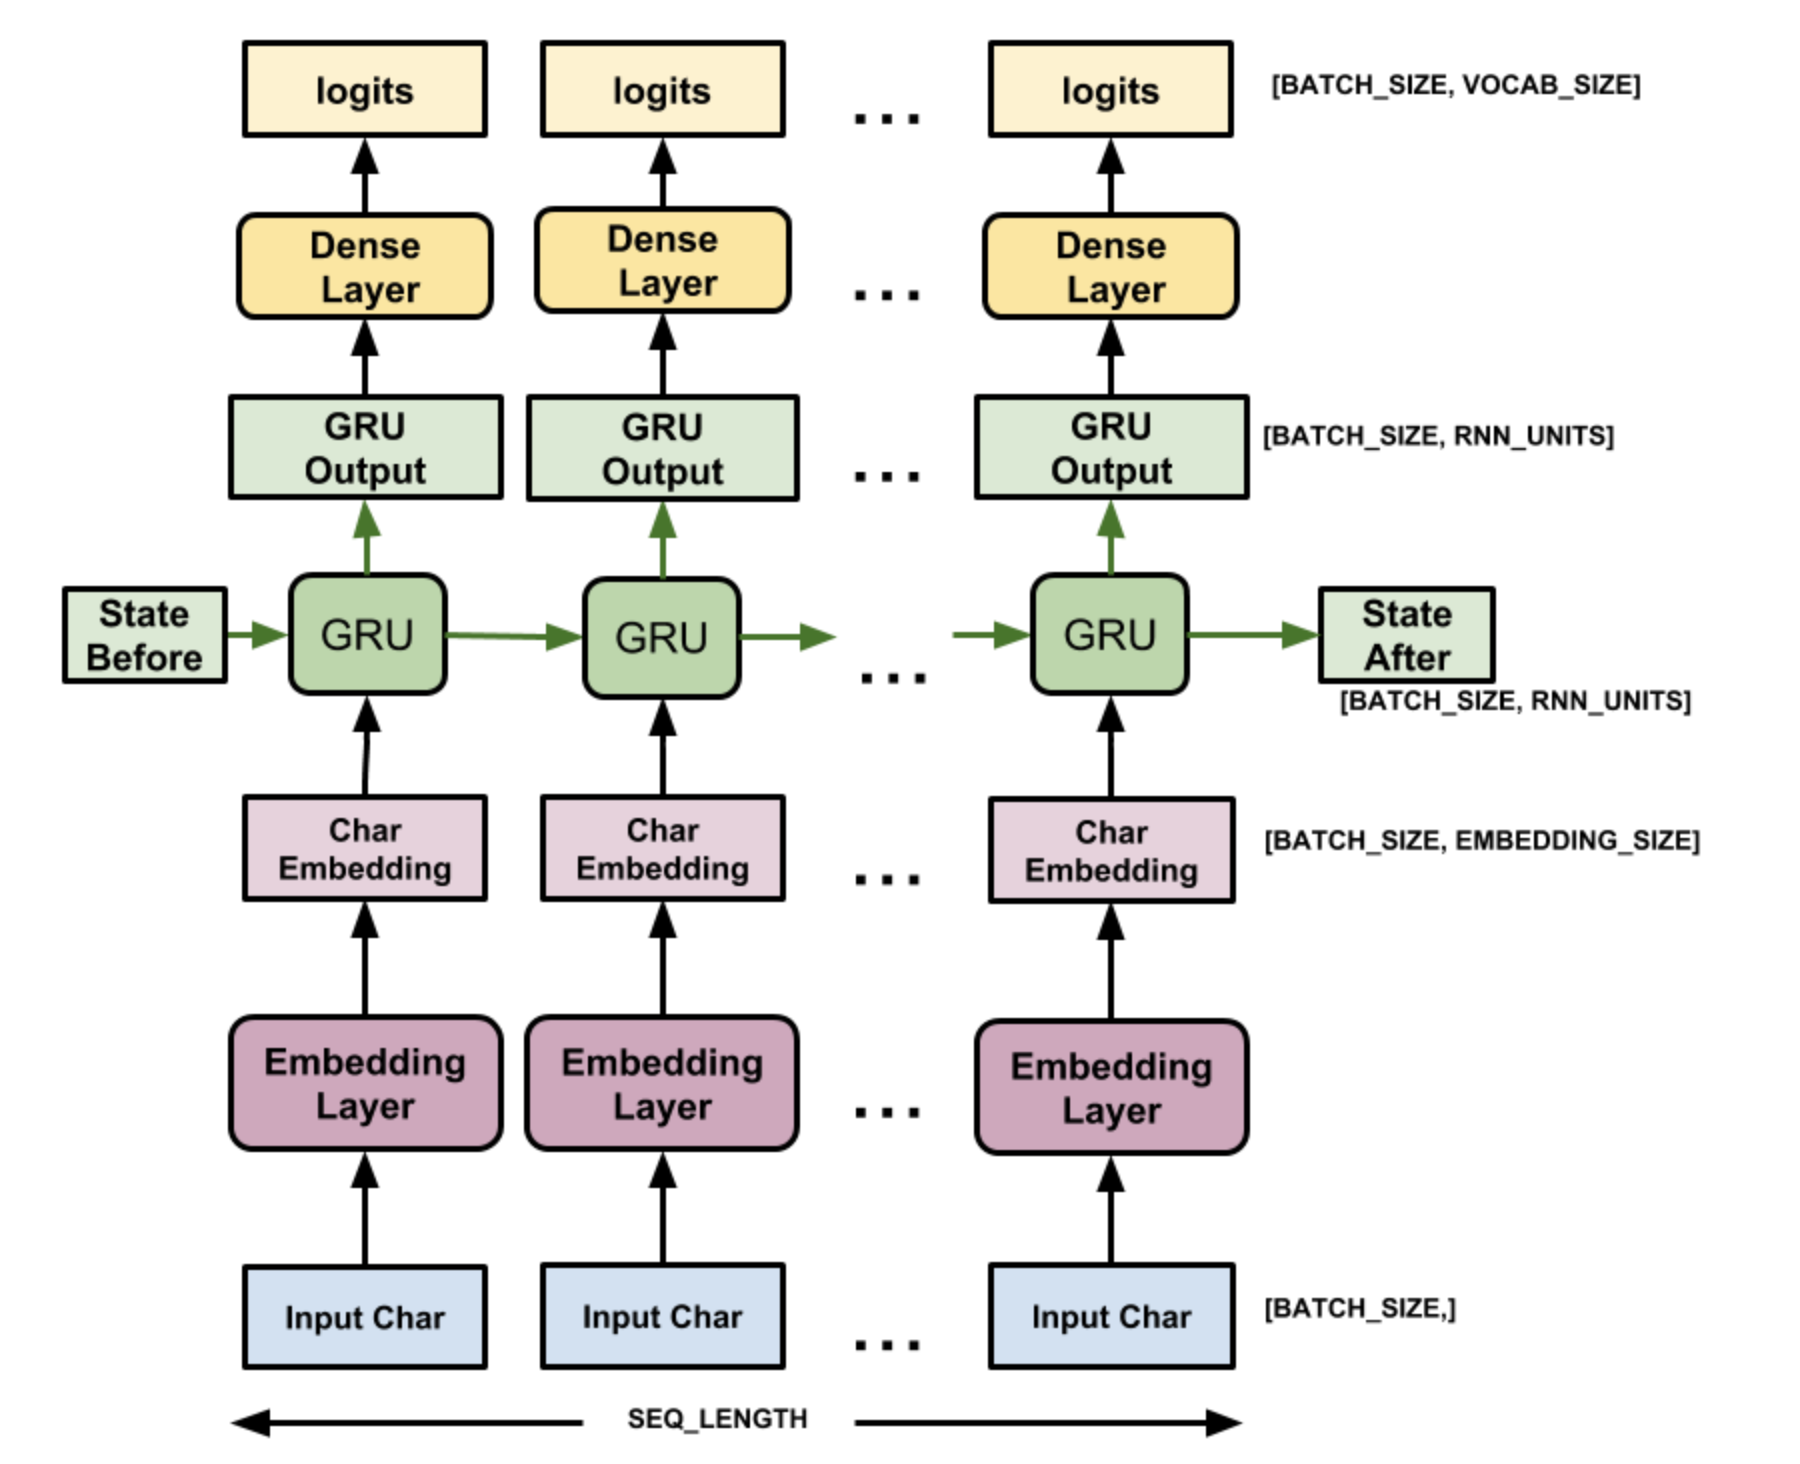

In [ ]:
for input_example_batch, target_example_batch in dataset.take(1):
    example_batch_predictions = model(input_example_batch)
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")


(64, 50, 72) # (batch_size, sequence_length, vocab_size)


In [ ]:
model.summary()

Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       multiple                  18432     
                                                                 
 gru (GRU)                   multiple                  3938304   
                                                                 
 batch_normalization (BatchN  multiple                 4096      
 ormalization)                                                   
                                                                 
 dense (Dense)               multiple                  1049600   
                                                                 
 dense_1 (Dense)             multiple                  1049600   
                                                                 
 dense_2 (Dense)             multiple                  73800     
                                                          

In [ ]:
sampled_indices = tf.random.categorical(example_batch_predictions[0], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices, axis=-1).numpy()
print("Input:\n", text_from_ids(input_example_batch[0]).numpy())
print()
print("Next Char Predictions:\n", text_from_ids(sampled_indices).numpy())

Input:
 b"ok of numbers, and then i realized, i don't have y"

Next Char Predictions:
 b"5asmbvs\xd9\x88zz\xe2\x80\x94aiajryh]d'6\xe2\x80\xa68\t;ja8\xe2\x80\xa6_4&_vnwlbr4*/$\xe2\x80\x98&9[UNK]\r("


## Training the Model

In [ ]:
loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True)

In [ ]:
example_batch_mean_loss = loss(target_example_batch, example_batch_predictions)
print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)")
print("Mean loss:        ", example_batch_mean_loss)

Prediction shape:  (64, 50, 72)  # (batch_size, sequence_length, vocab_size)
Mean loss:         tf.Tensor(4.2766323, shape=(), dtype=float32)


In [ ]:
tf.exp(example_batch_mean_loss).numpy()
# high number = badly initialized and model knows it's wrong

71.99757

In [ ]:
model.compile(optimizer='adam', loss=loss)

In [ ]:
# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

In [ ]:
dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(64, 50), dtype=tf.int64, name=None), TensorSpec(shape=(64, 50), dtype=tf.int64, name=None))>

In [ ]:
EPOCHS = 225
# history = model.fit(dataset, epochs=EPOCHS, callbacks=[checkpoint_callback])
history = model.fit(train_dataset, epochs=EPOCHS, validation_data=(test_dataset), callbacks=[checkpoint_callback])

# history_l2 = model_l2.fit(X_train_scaled,
#          y_train_scaled,verbose=0,
#          batch_size=100,
#          epochs=500,
#          validation_data=(X_test_scaled, y_test_scaled),
#          callbacks=[checkpointer])



Epoch 1/225
33/33 [==============================] - 9s 142ms/step - loss: 16.7348 - val_loss: 6.9169
Epoch 2/225
33/33 [==============================] - 2s 67ms/step - loss: 3.7843 - val_loss: 3.6704
Epoch 3/225
33/33 [==============================] - 2s 58ms/step - loss: 2.6208 - val_loss: 3.4133
Epoch 4/225
33/33 [==============================] - 2s 63ms/step - loss: 2.5010 - val_loss: 3.3774
Epoch 5/225
33/33 [==============================] - 3s 90ms/step - loss: 2.4519 - val_loss: 3.3314
Epoch 6/225
33/33 [==============================] - 2s 61ms/step - loss: 2.4100 - val_loss: 3.2478
Epoch 7/225
33/33 [==============================] - 2s 57ms/step - loss: 2.3877 - val_loss: 3.1534
Epoch 8/225
33/33 [==============================] - 2s 64ms/step - loss: 2.3658 - val_loss: 3.0641
Epoch 9/225
33/33 [==============================] - 3s 70ms/step - loss: 2.3431 - val_loss: 2.9505
Epoch 10/225
33/33 [==============================] - 3s 65ms/step - loss: 2.3284 - val_loss: 2.86

In [ ]:
print(history.history)

{'loss': [11.868451118469238, 3.4683847427368164, 2.6764729022979736, 2.457324981689453, 2.3434078693389893, 2.271286964416504, 2.2154672145843506, 2.180023431777954, 2.1501455307006836, 2.1214897632598877, 2.0975146293640137, 2.079047203063965, 2.061579465866089, 2.0429649353027344, 2.030914545059204, 2.014392852783203, 2.004362106323242, 1.9922834634780884, 1.981000542640686, 1.9718824625015259, 1.9684216976165771, 1.9578871726989746, 1.9457606077194214, 1.9412206411361694, 1.932167887687683, 1.924911379814148, 1.9209449291229248, 1.9129970073699951, 1.9078763723373413, 1.9003268480300903], 'val_loss': [5.798295021057129, 4.220984935760498, 3.767662763595581, 3.415147304534912, 3.1779959201812744, 3.0438742637634277, 3.0400590896606445, 3.0490198135375977, 3.044168472290039, 3.0577454566955566, 3.0898706912994385, 3.0453927516937256, 3.0782628059387207, 3.1296396255493164, 3.128619909286499, 3.1134114265441895, 3.098254919052124, 3.1011602878570557, 3.138962745666504, 3.0768198966979

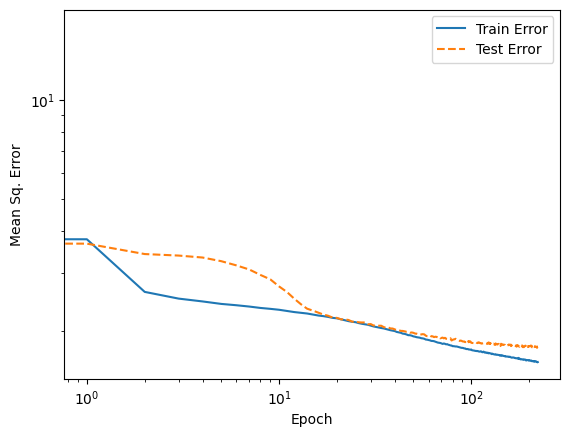

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def plot_history(history,name="tmp"):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch
  #print(int(np.log10(hist.shape[0])/1000.0))
  points = np.unique(np.array(10**np.arange(0,(np.log10(hist.shape[0])),(np.log10(hist.shape[0])/1000.0))-1,dtype=int))
  #print(points)
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Sq. Error')
  plt.loglog(hist['epoch'][points], hist['loss'][points],
           label='Train Error')
  plt.semilogy(hist['epoch'][points], hist['val_loss'][points],'--',
           label = 'Test Error')
  plt.legend()

plot_history(history)
plt.show()
# plotting the error
# model.load_weights(checkpoint_dir)

In [ ]:
class OneStep(tf.keras.Model):
  def __init__(self, model, chars_from_ids, ids_from_chars, temperature=1.0):
    super().__init__()
    self.temperature = temperature
    self.model = model
    self.chars_from_ids = chars_from_ids
    self.ids_from_chars = ids_from_chars

    # Create a mask to prevent "[UNK]" from being generated.
    skip_ids = self.ids_from_chars(['[UNK]'])[:, None]
    sparse_mask = tf.SparseTensor(
        # Put a -inf at each bad index.
        values=[-float('inf')]*len(skip_ids),
        indices=skip_ids,
        # Match the shape to the vocabulary
        dense_shape=[len(ids_from_chars.get_vocabulary())])
    self.prediction_mask = tf.sparse.to_dense(sparse_mask)

  @tf.function
  def generate_one_step(self, inputs, states=None):
    # Convert strings to token IDs.
    input_chars = tf.strings.unicode_split(inputs, 'UTF-8')
    input_ids = self.ids_from_chars(input_chars).to_tensor()

    # Run the model.
    # predicted_logits.shape is [batch, char, next_char_logits]
    predicted_logits, states = self.model(inputs=input_ids, states=states,
                                          return_state=True)
    # Only use the last prediction.
    predicted_logits = predicted_logits[:, -1, :]
    predicted_logits = predicted_logits/self.temperature
    # Apply the prediction mask: prevent "[UNK]" from being generated.
    predicted_logits = predicted_logits + self.prediction_mask

    # Sample the output logits to generate token IDs.
    predicted_ids = tf.random.categorical(predicted_logits, num_samples=1)
    predicted_ids = tf.squeeze(predicted_ids, axis=-1)

    # Convert from token ids to characters
    predicted_chars = self.chars_from_ids(predicted_ids)

    # Return the characters and model state.
    return predicted_chars, states

  @tf.function
  def generate_one_step_lstm(self, inputs, states=None, states2=None):
    # Convert strings to token IDs.
    input_chars = tf.strings.unicode_split(inputs, 'UTF-8')
    input_ids = self.ids_from_chars(input_chars).to_tensor()

    # Run the model.
    # predicted_logits.shape is [batch, char, next_char_logits]
    predicted_logits, states, states2 = self.model(inputs=input_ids, states=states, states2=states2,
                                          return_state=True)
    # Only use the last prediction.
    predicted_logits = predicted_logits[:, -1, :]
    predicted_logits = predicted_logits/self.temperature
    # Apply the prediction mask: prevent "[UNK]" from being generated.
    predicted_logits = predicted_logits + self.prediction_mask

    # Sample the output logits to generate token IDs.
    predicted_ids = tf.random.categorical(predicted_logits, num_samples=1)
    predicted_ids = tf.squeeze(predicted_ids, axis=-1)

    # Convert from token ids to characters
    predicted_chars = self.chars_from_ids(predicted_ids)

    # Return the characters and model state.
    return predicted_chars, states, states2

In [ ]:
one_step_model = OneStep(model, chars_from_ids, ids_from_chars)


In [ ]:
start = time.time()
states = None
# for lstm2
# states2 = None
next_char = tf.constant(['hello'])
result = [next_char]

for n in range(1000):
  next_char, states = one_step_model.generate_one_step(next_char, states=states)

  # for lstm2
  # next_char, states, states2 = one_step_model.generate_one_step_lstm(next_char, states=states, states2=states2)
  result.append(next_char)

result = tf.strings.join(result)
end = time.time()
print(result[0].numpy().decode('utf-8'), '\n\n' + '_'*80)
print('\nRun time:', end - start)

hellod do everyded you a— ito long sous, i good morning sorgaring times of i say to have eness?
	you wow because you are if. many top into be like a goods cale numisbhaps
	how i just have a in.
	sup.but it my beat?
	you're a biluine and b-blijust.
	it's time on misssy.
	roses of your exteng in buy.
	hany any! and i give me your mission letally love ut…
	girll.
	i goes unlic put tfll the right when i onlarty with if is it like do you.
	dick you lorglartie, you all nights stick in your face so you boat ane blue!
	if i loves your a” 	came like lix smeophebabe? because if i dove you olot this are like and dojamof around i kruke my with you.
	i was regleeps.
	you off nother sysitayerish?
	if i had red all able bedy so ow muc'f inting my babe, are you a firl you.
	whoge'c son that uce i want to tnees something you’re and kruck you will.
	give lo's 7c0kt, and dorths.
	you like i care a mebalue been or instrargial hand love, is my xheet inside.
	was vithing out of in your mat2boas 

__________